In [1]:
from tqdm import tqdm
from glob import glob
from matplotlib.colors import ListedColormap
from EmbedSeg.utils.preprocess_data import extract_data, split_train_val, split_train_crops, get_data_properties
from EmbedSeg.utils.generate_crops import *
from EmbedSeg.utils.visualize import visualize_many_crops, visualize_3d
from EmbedSeg.utils.create_dicts import create_dataset_dict, create_model_dict, create_loss_dict, create_configs, create_test_configs_dict

from EmbedSeg.train import begin_training
from EmbedSeg.test import begin_evaluating
import json, tifffile, numpy as np, os, torch
%matplotlib inline

/home/manan/.local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


<div class="alert alert-block alert-info"> <b> 
    In this notebook, we shall solve an integer linear problem (ILP) which minimizes such a cost function by training a 2D model, applying the trained model independently on the slices of a 3D stack and then re-assigning the ids such that a certain cost function is minimized. </b> 
</div>


><u>Note</u>: One would need a `gurobi` license to be able to run the optimization

### Download data

>The images and corresponding masks are downloaded from an external url, specified by `zip_url` to the path specified by the variables `data_dir` and `project_name`, using `extract_data` function. 
Next, the `train` directories are split into `train` and `val` using `split_train_val`, but for now we don't transfer any images into the `val` directory (`subset = 0.0`)

In [2]:
data_dir = '../../data'
project_name = 'Mouse-Skull-Nuclei-CBG-ilp'

In [3]:
extract_data(
    zip_url = 'https://github.com/juglab/EmbedSeg/releases/download/v0.1.0/Mouse-Skull-Nuclei-CBG.zip',
    data_dir = data_dir,
    project_name = project_name,
)

Zip file was downloaded and extracted before!


In [4]:
split_train_val(
    data_dir = data_dir,
    project_name = project_name, 
    train_val_name = 'train',
    subset = 0.0)

Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-ilp/train/images/
Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-ilp/train/masks/
Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-ilp/val/images/
Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-ilp/val/masks/
Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-ilp/test/images/
Created new directory : ../../data/Mouse-Skull-Nuclei-CBG-ilp/test/masks/
Train-Val-Test Images/Masks copied to ../../data/Mouse-Skull-Nuclei-CBG-ilp


### Specify desired centre location for spatial embedding of pixels

>Interior pixels of an object instance can either be embedded at the `medoid` or the `centroid`.

In [3]:
center = 'medoid' # 'medoid', 'centroid'

### Calculate some dataset specific properties

>In the next cell, we will calculate properties of the data such as `min_object_size`, `foreground_weight` etc. 
We can also specify some properties, for example, set `data_properties_dir['data_type']='16-bit'` if the images are of datatype `unsigned 16 bit` and `data_properties_dir['data_type']='8-bit'` if the images are of datatype `unsigned 8 bit`.

In [4]:
data_properties_dir = get_data_properties(data_dir, project_name, train_val_name=['train'], 
                                          test_name=['test'], mode='3d_ilp')

data_properties_dir['data_type']='16-bit'
data_properties_dir['pixel_size_x_microns']=0.073 # set equal to voxel size (microns) in x dimension
data_properties_dir['pixel_size_y_microns']=0.073 # set equal to voxel size (microns) in y dimension
data_properties_dir['pixel_size_z_microns']=0.20 # set equal to voxel size (microns) in z dimension
data_type, foreground_weight, n_y, n_x, pixel_size_x_microns, pixel_size_z_microns, min_object_size, mean_object_size, max_object_size = data_properties_dir['data_type'], float(data_properties_dir['foreground_weight']),  int(data_properties_dir['n_y']), int(data_properties_dir['n_x']),  float(data_properties_dir['pixel_size_x_microns']), float(data_properties_dir['pixel_size_z_microns']), int(data_properties_dir['min_object_size']), int(data_properties_dir['mean_object_size']), int(data_properties_dir['max_object_size'])

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Foreground weight of the `Mouse-Skull-Nuclei-CBG-ilp` dataset set equal to 10.000


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Minimum object size of the `Mouse-Skull-Nuclei-CBG-ilp` dataset is equal to 1
Mean object size of the `Mouse-Skull-Nuclei-CBG-ilp` dataset is equal to 2410.841243616702
Maximum object size of the `Mouse-Skull-Nuclei-CBG-ilp` dataset is equal to 10810.21799999998
Average object size of the `Mouse-Skull-Nuclei-CBG-ilp` dataset along `x` is equal to 47.700
Std. dev object size of the `Mouse-Skull-Nuclei-CBG-ilp` dataset along `x` is equal to 23.115
Average object size of the `Mouse-Skull-Nuclei-CBG-ilp` dataset along `y` is equal to 88.298
Std. dev object size of the `Mouse-Skull-Nuclei-CBG-ilp` dataset along `y` is equal to 41.230
Tile size of the `Mouse-Skull-Nuclei-CBG-ilp` dataset set equal to (512, 512)


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s]

Average background intensity of the `Mouse-Skull-Nuclei-CBG-ilp` dataset set equal to 124.718


>Investigate how `data_properties_dir` looks like!

In [5]:
data_properties_dir

{'foreground_weight': 10.0,
 'min_object_size': 1.0,
 'mean_object_size': 2410.841243616702,
 'max_object_size': 10810.21799999998,
 'avg_object_size_z': None,
 'avg_object_size_y': 88.29768699309102,
 'avg_object_size_x': 47.699759687593875,
 'stdev_object_size_z': None,
 'stdev_object_size_y': 41.230287596096005,
 'stdev_object_size_x': 23.115318216703447,
 'n_z': None,
 'n_y': 512.0,
 'n_x': 512.0,
 'one_hot': False,
 'avg_background_intensity': 124.71846355642086,
 'project_name': 'Mouse-Skull-Nuclei-CBG-ilp',
 'data_type': '16-bit',
 'pixel_size_x_microns': 0.073,
 'pixel_size_y_microns': 0.073,
 'pixel_size_z_microns': 0.2}

### Specify cropping configuration parameters

>Images and the corresponding masks are cropped into patches centred around an object instance, which are pre-saved prior to initiating the training. Note that the cropped images, masks and center-images would be saved at the path specified by `crops_dir` (The parameter `crops_dir` is set to ```./crops``` by default, which creates a directory at the same location as this notebook).  
Note that we automatically calculate  the `crop_size` by using the `avg_object_size` and `std_object_size` through the relation:  
$\text{crop_size_i} = \text{avg_obj_size_i} + \text{n_sigma} \times \text{std_obj_size_i}$ where $i \in \{x,y\}$.  

In [6]:
n_sigma = 5

In [7]:
def round_up_8(x):
    return (x.astype(int)+7) & (-8)

In [8]:
crops_dir = './crops'
max_size = np.max([
    round_up_8(data_properties_dir['avg_object_size_y'] + n_sigma*data_properties_dir['stdev_object_size_y']),
    round_up_8(data_properties_dir['avg_object_size_x'] + n_sigma*data_properties_dir['stdev_object_size_x'])])
crop_size_x = max_size
crop_size_y = max_size
print("Crop size in x and y will be set equal to {}".format(crop_size_x))


Crop size in x and y will be set equal to 296


### Generate Crops

>Images are normalized using `min-max-percentile` scheme (by default) and then cropped and saved using the `process_3d_sliced` method. Other options for normalization are `absolute` and `mean-std`.  
Here, `data_subset` defines the directory which is processed. 

In [9]:
norm = 'min-max-percentile' # min-max-percentile, absolute, mean-std

In [12]:
data_subsets = ['train'] 
for data_subset in data_subsets:
    image_dir = os.path.join(data_dir, project_name, data_subset, 'images')
    instance_dir = os.path.join(data_dir, project_name, data_subset, 'masks')
    image_names = sorted(glob(os.path.join(image_dir, '*.tif'))) 
    instance_names = sorted(glob(os.path.join(instance_dir, '*.tif')))  
    for i in tqdm(np.arange(len(image_names))):
        process_3d_ilp(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, 
                crop_size_x = crop_size_x, crop_size_y = crop_size_y, center = center, norm=norm, data_type = data_properties_dir['data_type'],  
                fraction_max_ids=0.25)
    print("Cropping of images, instances and centre_images for data_subset = `{}` done!".format(data_subset))

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Created new directory : ./crops/Mouse-Skull-Nuclei-CBG-ilp/train/images/
Created new directory : ./crops/Mouse-Skull-Nuclei-CBG-ilp/train/masks/
Created new directory : ./crops/Mouse-Skull-Nuclei-CBG-ilp/train/center-medoid/


100%|████████████████████████████████████████████| 2/2 [07:15<00:00, 217.95s/it]

Cropping of images, instances and centre_images for data_subset = `train` done!


### Keep some crops for validation

>Since there were only $2$ train image volumes, instead of reserving a subset of image volumes for validation (as is general practice),  we reserve some of the crops generated from the train image volumes for validation.

In [ ]:
split_train_crops(project_name = project_name, center = center, crops_dir = crops_dir, subset = 0.15)

### Visualize cropped images, corresponding ground truth masks and object center images 

>Some of these cropped images and their label masks are visualized. The label masks are colored with a glasbey-style color map stored in `new_cmap`.

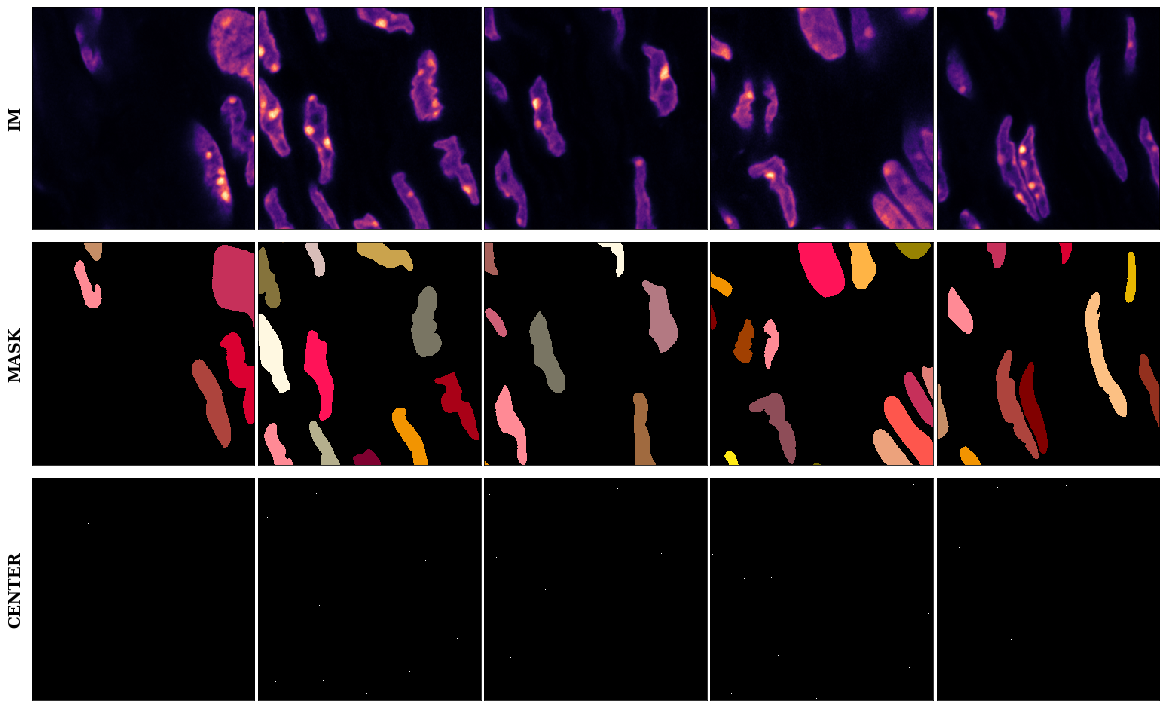

In [10]:
new_cmap = np.load('../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_many_crops(data_dir=crops_dir, project_name=project_name, train_val_dir='val', center=center, n_images=5, new_cmp=new_cmap)

### Specify training dataset-related parameters

>We create a `train_dataset_dict` dictionary using the crops extracted from the train images and masks 

In [15]:
train_dataset_dict = create_dataset_dict(data_dir = crops_dir, 
                                         project_name = project_name,  
                                         center = center, 
                                         size = len(os.listdir(os.path.join(crops_dir, project_name, 'train', 'images'))), 
                                         batch_size = 16, 
                                         type = 'train')

`train_dataset_dict` dictionary successfully created with: 
 -- train images accessed from ./crops/Mouse-Skull-Nuclei-CBG-ilp/train/images, 
 -- number of images per epoch equal to 977, 
 -- batch size set at 16, 
 -- virtual batch multiplier set as 1, 
 -- one_hot set as False, 


### Specify val dataset-related parameters

>We create a `val_dataset_dict` dictionary using the crops extracted from the val images and masks 

In [16]:
val_dataset_dict = create_dataset_dict(data_dir = crops_dir, 
                                       project_name = project_name, 
                                       center = center, 
                                       size = len(os.listdir(os.path.join(crops_dir, project_name, 'val', 'images'))), 
                                       batch_size = 16, 
                                       type ='val',)

`val_dataset_dict` dictionary successfully created with: 
 -- val images accessed from ./crops/Mouse-Skull-Nuclei-CBG-ilp/val/images, 
 -- number of images per epoch equal to 172, 
 -- batch size set at 16, 
 -- virtual batch multiplier set as 1, 
 -- one_hot set as False, 


### Specify model-related parameters

>Set the `input_channels` attribute equal to the number of channels in the input images. 
In the cell after this one, a `model_dataset_dict` and a `loss_dict` dictionary is created.

In [17]:
model_dict = create_model_dict(input_channels = 1)
loss_dict = create_loss_dict()

`model_dict` dictionary successfully created with: 
 -- num of classes equal to 1, 
 -- input channels equal to [4, 1], 
 -- name equal to branched_erfnet
`loss_dict` dictionary successfully created with: 
 -- foreground weight equal to 10.000, 
 -- w_inst equal to 1, 
 -- w_var equal to 10, 
 -- w_seed equal to 1


### Specify the duration of training by setting `n_epochs`

In the cell after this one, a `configs` dictionary is created.  
The model weights are saved by default at `experiment/Mouse-Skull-Nuclei-CBG-sliced-demo`

In [18]:
n_epochs = 20

In [19]:
configs = create_configs(save_dir = os.path.join('experiment', project_name+'-'+'demo'), 
                         n_epochs=n_epochs,
                         resume_path=None,
                         n_y = n_y, 
                         n_x = n_x,)

`configs` dictionary successfully created with: 
 -- n_epochs equal to 20, 
 -- display equal to False, 
 -- save_dir equal to experiment/Mouse-Skull-Nuclei-CBG-ilp-demo, 
 -- n_z equal to None, 
 -- n_y equal to 512, 
 -- n_x equal to 512, 
 -- one_hot equal to False, 


### Begin training!

>We input the dictionaries created above to the `begin_training` function 

In [ ]:
%matplotlib Agg
begin_training(train_dataset_dict, val_dataset_dict, model_dict, loss_dict, configs)

### Evaluate using your trained model weights 

>Use the model trained by you for $20$ epochs

In [11]:
checkpoint_path = os.path.join('experiment', project_name+'-'+'demo', 'best_iou_model.pth')

### Set `tta=True` for better inference

> Setting `tta=True` leads to improved performance, but the trained model takes *longer* to predict per image.  
In the cell after this one, a `test_configs` dictionary is created.

In [12]:
tta = True
save_dir = './inference/' + project_name

In [13]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        tta = tta, 
                                        min_object_size = min_object_size, 
                                        mean_object_size = mean_object_size,
                                        max_object_size = max_object_size,
                                        save_dir = save_dir,
                                        norm = norm, 
                                        data_type = data_type,
                                        n_y = n_y,
                                        n_x = n_x,
                                        name = '3d_ilp',
                                        )

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../data/Mouse-Skull-Nuclei-CBG-ilp, 
 -- trained weights accessed from experiment/Mouse-Skull-Nuclei-CBG-ilp-demo/best_iou_model.pth, 
 -- output directory chosen as ./inference/Mouse-Skull-Nuclei-CBG-ilp


### Evaluate on unseen test data

>The `test_configs` dictionary created above, is input to the `begin_evaluating` function.

In [14]:
begin_evaluating(test_configs)

3-D `test` dataloader created! Accessing data from ../../data/Mouse-Skull-Nuclei-CBG-ilp/test/
Number of images in `test` directory is 1
Number of instances in `test` directory is 1
Number of center images in `test` directory is 0
*************************
Creating Branched Erfnet with [4, 1] outputs


100%|█████████████████████████████████████████| 125/125 [00:16<00:00,  7.40it/s]


Set parameter Username
Academic license - for non-commercial use only - expires 2022-08-07
Building Graph ...


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 167.46it/s]

Nodes added ...



100%|█████████████████████████████████████████| 125/125 [00:51<00:00,  2.44it/s]

Edges added ...
Model initialized ...
Constraints added ...


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 3192 rows, 7775 columns and 12376 nonzeros
Model fingerprint: 0x300c6da7
Variable types: 0 continuous, 7775 integer (7775 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 237.3228069
Presolve removed 3192 rows and 7775 columns
Presolve time: 0.03s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.02 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 113.543 237.323 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.135430195360e+02, best bound 1.135430195360e+02, gap 0.0000%
Model optimized over variables ...


100%|████████████████████████████████████| 7775/7775 [00:00<00:00, 60005.07it/s]

Ids reassigned  ...



100%|█████████████████████████████████████████████| 1/1 [01:12<00:00, 72.11s/it]

Mean Average Precision (AP_dsb) at IOU threshold = 0.5 at seediness threshold = 0.90000, is equal to 0.44444


{'fg_thresh': 0.5, 'AP_dsb_05': 0.4444444444444444}

In [15]:
%matplotlib inline
prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))
seed_file_names = sorted(glob(os.path.join(save_dir, 'seeds','*.tif')))

### Visualize some results on unseen test data

Image filename is X2_right.tif and index is 0


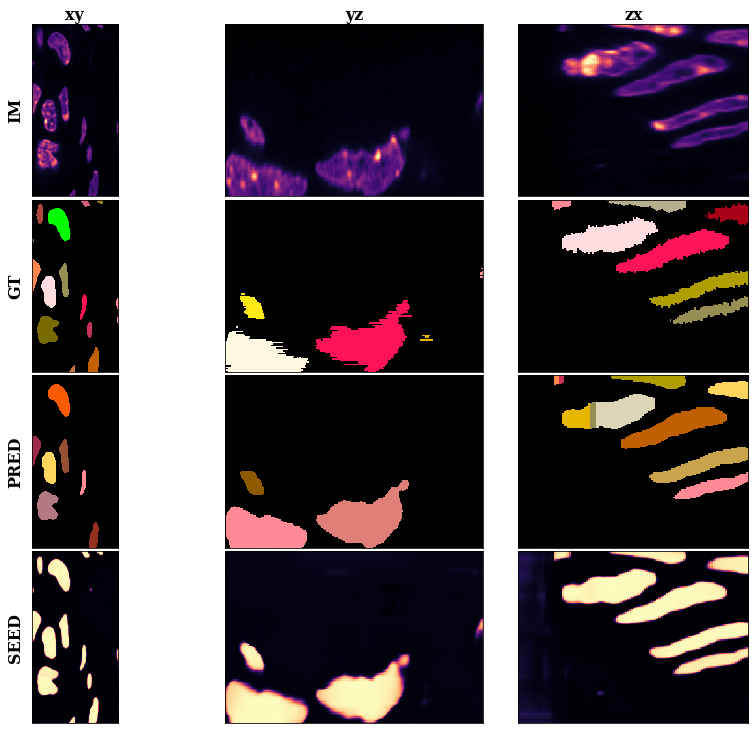

In [16]:
index = 0
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
visualize_3d(image_file_names[index], ground_truth_file_names[index], prediction_file_names[index], seed_file_names[index], new_cmap, anisotropy=pixel_size_z_microns/pixel_size_x_microns)

<div class="alert alert-block alert-info"> <b> How can you improve the model prediction? </b> For example, would longer training help? <br>
    Go above in the notebook and <u>resume training</u>  from the last checkpoint  </div>